In [12]:
# Check the DATA data
from unifier import unifier
import sys

In [1]:
Quarters = ["Q1", "Q2", "Q3","Q4"]
Years = range(2023,2025,1)
kq_dict = {}
mdna_dict = {}
for curr_year in Years:
    Quarters = [f"Q{n}" for n in [1, 2, 3, 4]]
    quarters = [f"{quarter}_{curr_year}" for quarter in Quarters]

    for q in quarters:
        print(f'querying unifier for {q} .  . .')
        df_10 = unifier.get_dataframe(name="deception_and_truth_10kq_quarterly", key=q)
        df_10["source"] = "10kq"
        kq_dict[q] = df_10

        # Checking for NoneType values in 'scorepublisheddate' column
        none_rows = df_10[df_10['scorepublisheddate'].isna()]

        if not none_rows.empty:
            print("Rows with NoneType in 'scorepublisheddate':")
            pd.set_option('display.max_columns', None)
            print(none_rows)
            # Terminate the program to prevent further errors    
            #sys.exit("Terminating due to NoneType values in 'scorepublisheddate'.")
            print("Terminating due to NoneType values in 'scorepublisheddate'.")

        # Load MD&A data
        df_md = unifier.get_dataframe(name="deception_and_truth_mdna_quarterly", key=q)
        df_md["source"] = "mdna"
        mdna_dict[q] = df_md

        # Checking for NoneType values in 'scorepublisheddate' column for MD&A data
        if 'scorepublisheddate' not in df_md.columns:
            print(f'Missing row in md_df:{print(df_md)}')
        none_md_rows = df_md[df_md['scorepublisheddate'].isna()]

        if not none_md_rows.empty:
            print("Rows with NoneType in 'scorepublisheddate' for MD&A data:")
            pd.set_option('display.max_columns', None)
            print(none_md_rows)
            # Terminate the program to prevent further errors
            #sys.exit("Terminating due to NoneType values in 'scorepublisheddate' for MD&A data.")
            print("Terminating due to NoneType values in 'scorepublisheddate' for MD&A data.")

        # # Load call transcripts data
        # df_t = unifier.get_dataframe(name="deception_and_truth_call_transcripts_quarterly", key=q)
        # df_t["source"] = "call transcripts"
        # t_dict[q] = df_t

querying unifier for Q1_2023 .  . .


NameError: name 'unifier' is not defined

In [20]:
mdna_dict.keys()

dict_keys(['Q1_2007', 'Q2_2007', 'Q3_2007', 'Q4_2007', 'Q1_2008', 'Q2_2008', 'Q3_2008', 'Q4_2008', 'Q1_2009', 'Q2_2009', 'Q3_2009', 'Q4_2009', 'Q1_2010', 'Q2_2010', 'Q3_2010', 'Q4_2010', 'Q1_2011', 'Q2_2011', 'Q3_2011', 'Q4_2011', 'Q1_2012', 'Q2_2012', 'Q3_2012', 'Q4_2012', 'Q1_2013', 'Q2_2013', 'Q3_2013', 'Q4_2013', 'Q1_2014', 'Q2_2014', 'Q3_2014', 'Q4_2014', 'Q1_2015', 'Q2_2015', 'Q3_2015', 'Q4_2015', 'Q1_2016', 'Q2_2016', 'Q3_2016', 'Q4_2016', 'Q1_2017', 'Q2_2017', 'Q3_2017', 'Q4_2017', 'Q1_2018', 'Q2_2018', 'Q3_2018', 'Q4_2018', 'Q1_2019', 'Q2_2019', 'Q3_2019', 'Q4_2019', 'Q1_2020', 'Q2_2020', 'Q3_2020', 'Q4_2020', 'Q1_2021', 'Q2_2021', 'Q3_2021', 'Q4_2021', 'Q1_2022', 'Q2_2022', 'Q3_2022', 'Q4_2022', 'Q1_2023', 'Q2_2023', 'Q3_2023', 'Q4_2023'])

#  Tearsheet code -  plotting.py code for generating tearsheets
* This seems to be leveraging pf to generate some artifacts that are not being created in the correct place
* [ ] Figure out if there is an environment variable that needs to be set up properly


Processing backtest results in /Users/morgan/repos/edge-seeker/zipline-x/AlphaFactor-Backtester-main/plots/temp/20241022_015936...
The Benchmark is Date
2020-01-10 00:00:00+00:00    0.000000
2020-01-13 00:00:00+00:00    0.006877
2020-01-14 00:00:00+00:00   -0.001525
2020-01-15 00:00:00+00:00    0.002260
2020-01-16 00:00:00+00:00    0.008318
                               ...   
2023-09-25 00:00:00+00:00    0.004205
2023-09-26 00:00:00+00:00   -0.014691
2023-09-27 00:00:00+00:00    0.000399
2023-09-28 00:00:00+00:00    0.005797
2023-09-29 00:00:00+00:00   -0.002427
Name: Return, Length: 937, dtype: float64 results_dir is /Users/morgan/repos/edge-seeker/zipline-x/AlphaFactor-Backtester-main/plots/temp/20241022_015936, LIVE_DATE is 2023-01-01
Table saved to ./plots/temp/table_20241025_162537291510.html
Table saved to ./plots/temp/table_20241025_162537330237.html


2024-10-25 16:25:55,676 - INFO - Saving Full Tear Sheet to ./plots/temp


Plot saved: ./plots/temp/Full Tear Sheet.png


2024-10-25 16:26:01,311 - INFO - Running create_interesting_times_tear_sheet


Table saved to ./plots/temp/table_20241025_162612657790.html


2024-10-25 16:27:21,512 - INFO - Saving Interesting Times Tear Sheet to ./plots/temp


Plot saved: ./plots/temp/Interesting Times Tear Sheet.png
Table saved to ./plots/temp/table_20241025_162730245830.html
Table saved to ./plots/temp/table_20241025_162730247689.html
Table saved to ./plots/temp/table_20241025_162730250085.html


2024-10-25 16:27:34,700 - INFO - Saving Position Tear Sheet to ./plots/temp


Plot saved: ./plots/temp/Position Tear Sheet.png


2024-10-25 16:27:36,936 - INFO - Saving TXN Tear Sheet to ./plots/temp


Plot saved: ./plots/temp/TXN Tear Sheet.png
Table saved to ./plots/temp/table_20241025_162847010652.html
Table saved to ./plots/temp/table_20241025_162847013208.html
Table saved to ./plots/temp/table_20241025_162847015765.html
Table saved to ./plots/temp/table_20241025_162847018164.html
Table saved to ./plots/temp/table_20241025_162847198815.html
Table saved to ./plots/temp/table_20241025_162847234775.html


2024-10-25 16:29:29,287 - INFO - Saving Round Trip Tear Sheet to ./plots/temp
2024-10-25 16:29:41,577 - INFO - Aggregated tearsheet saved to /Users/morgan/repos/edge-seeker/zipline-x/AlphaFactor-Backtester-main/plots/temp/20241022_015936/full_tearsheet.html


Plot saved: ./plots/temp/Round Trip Tear Sheet.png


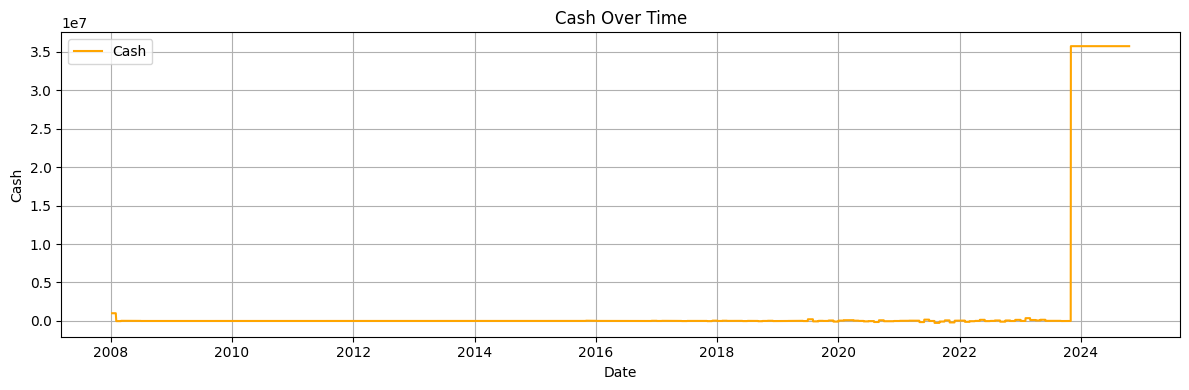

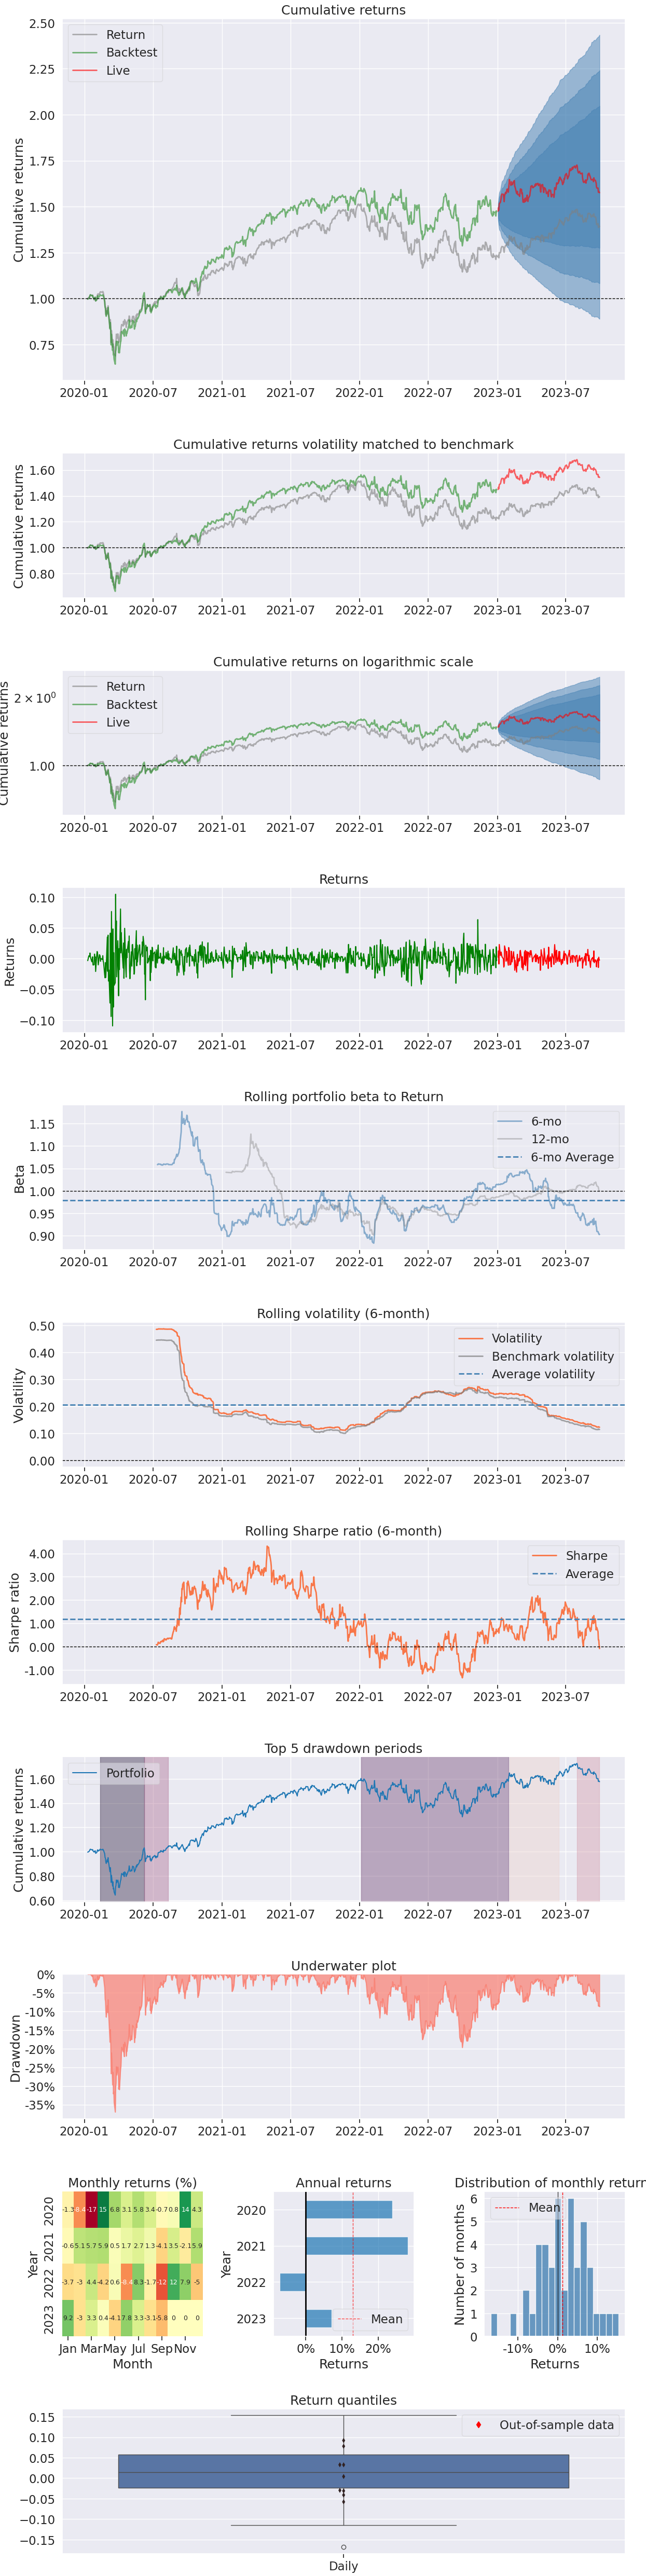

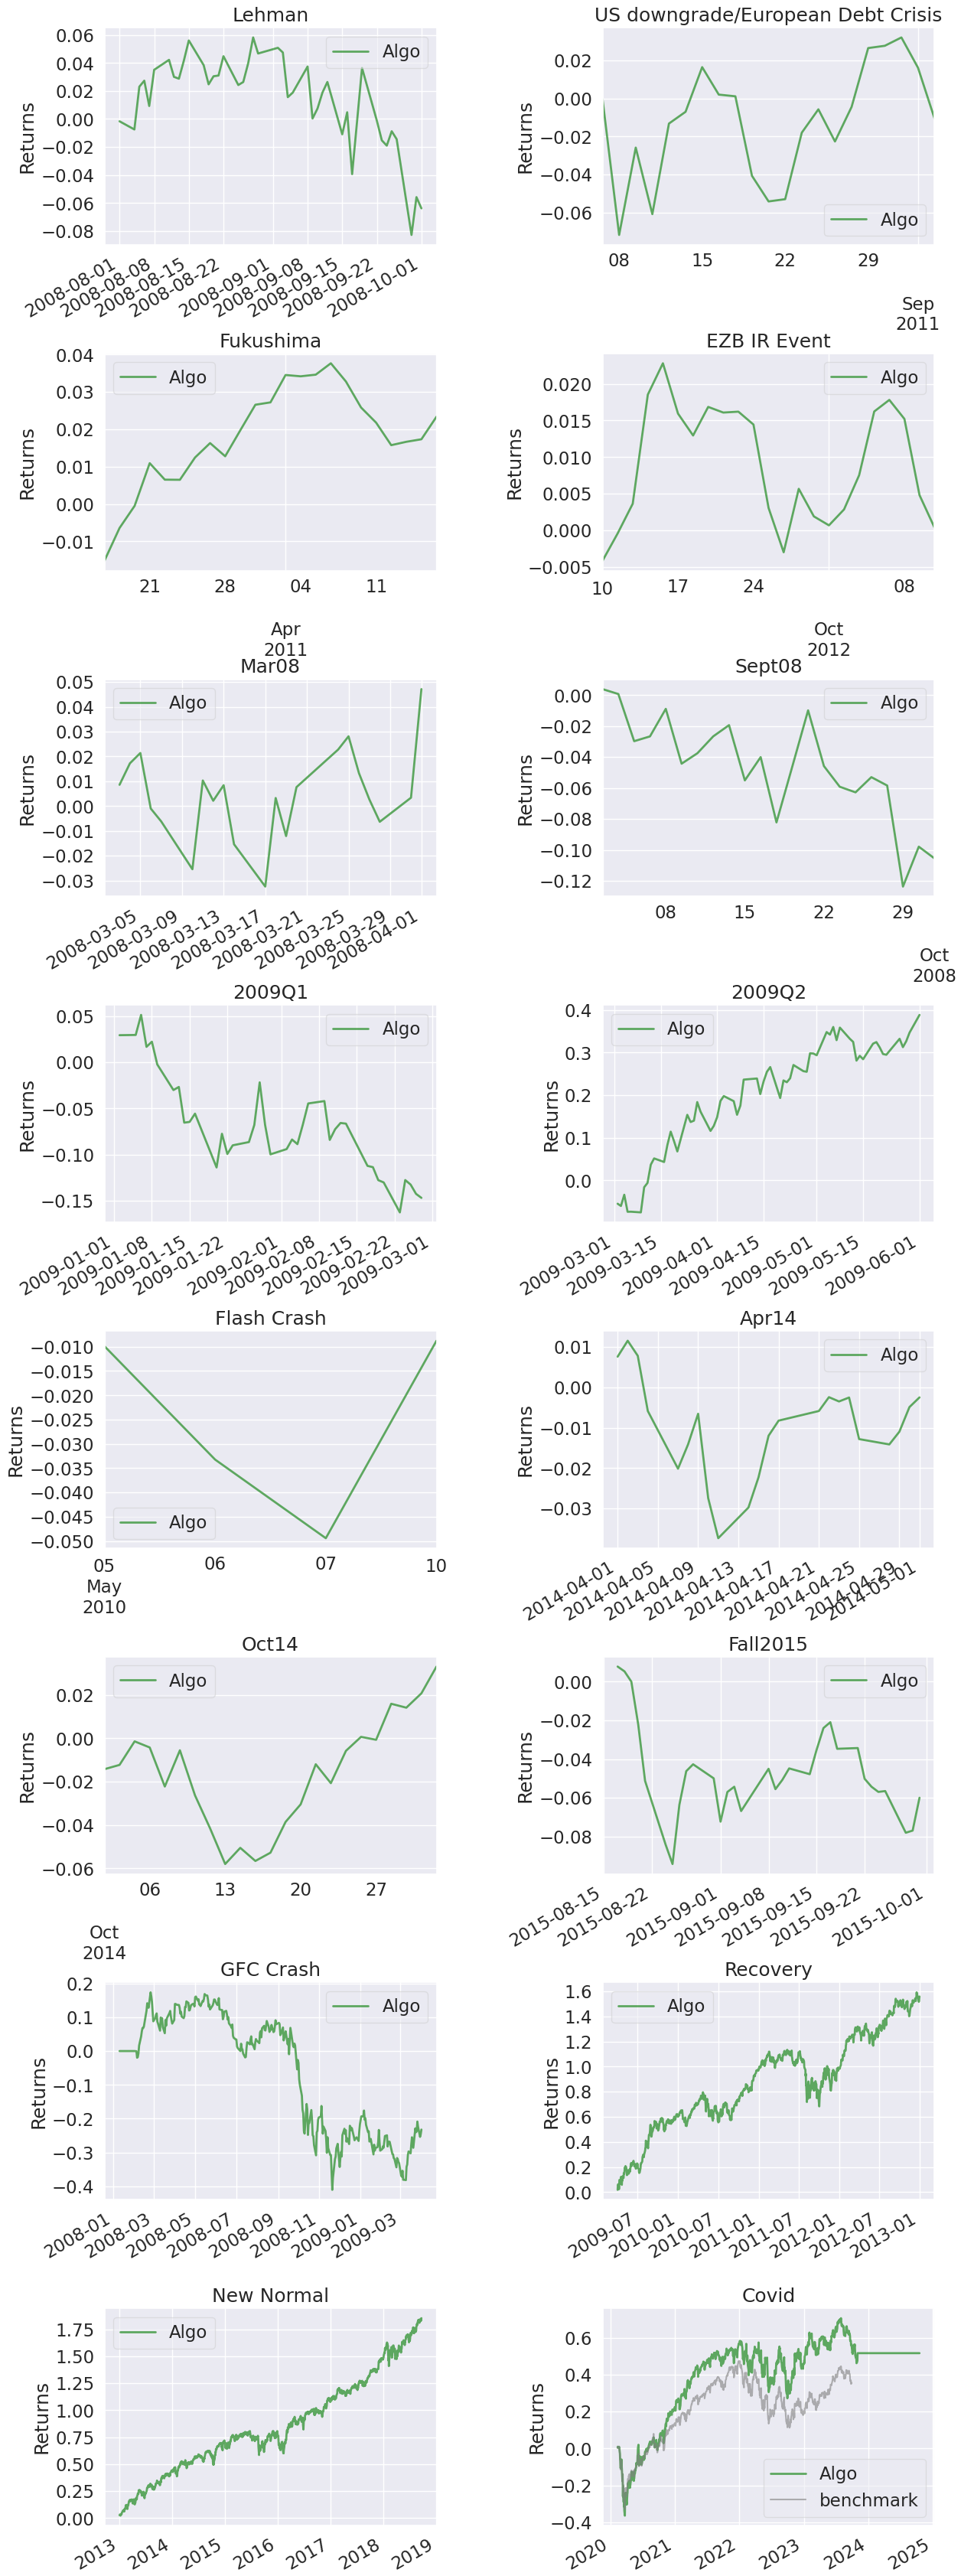

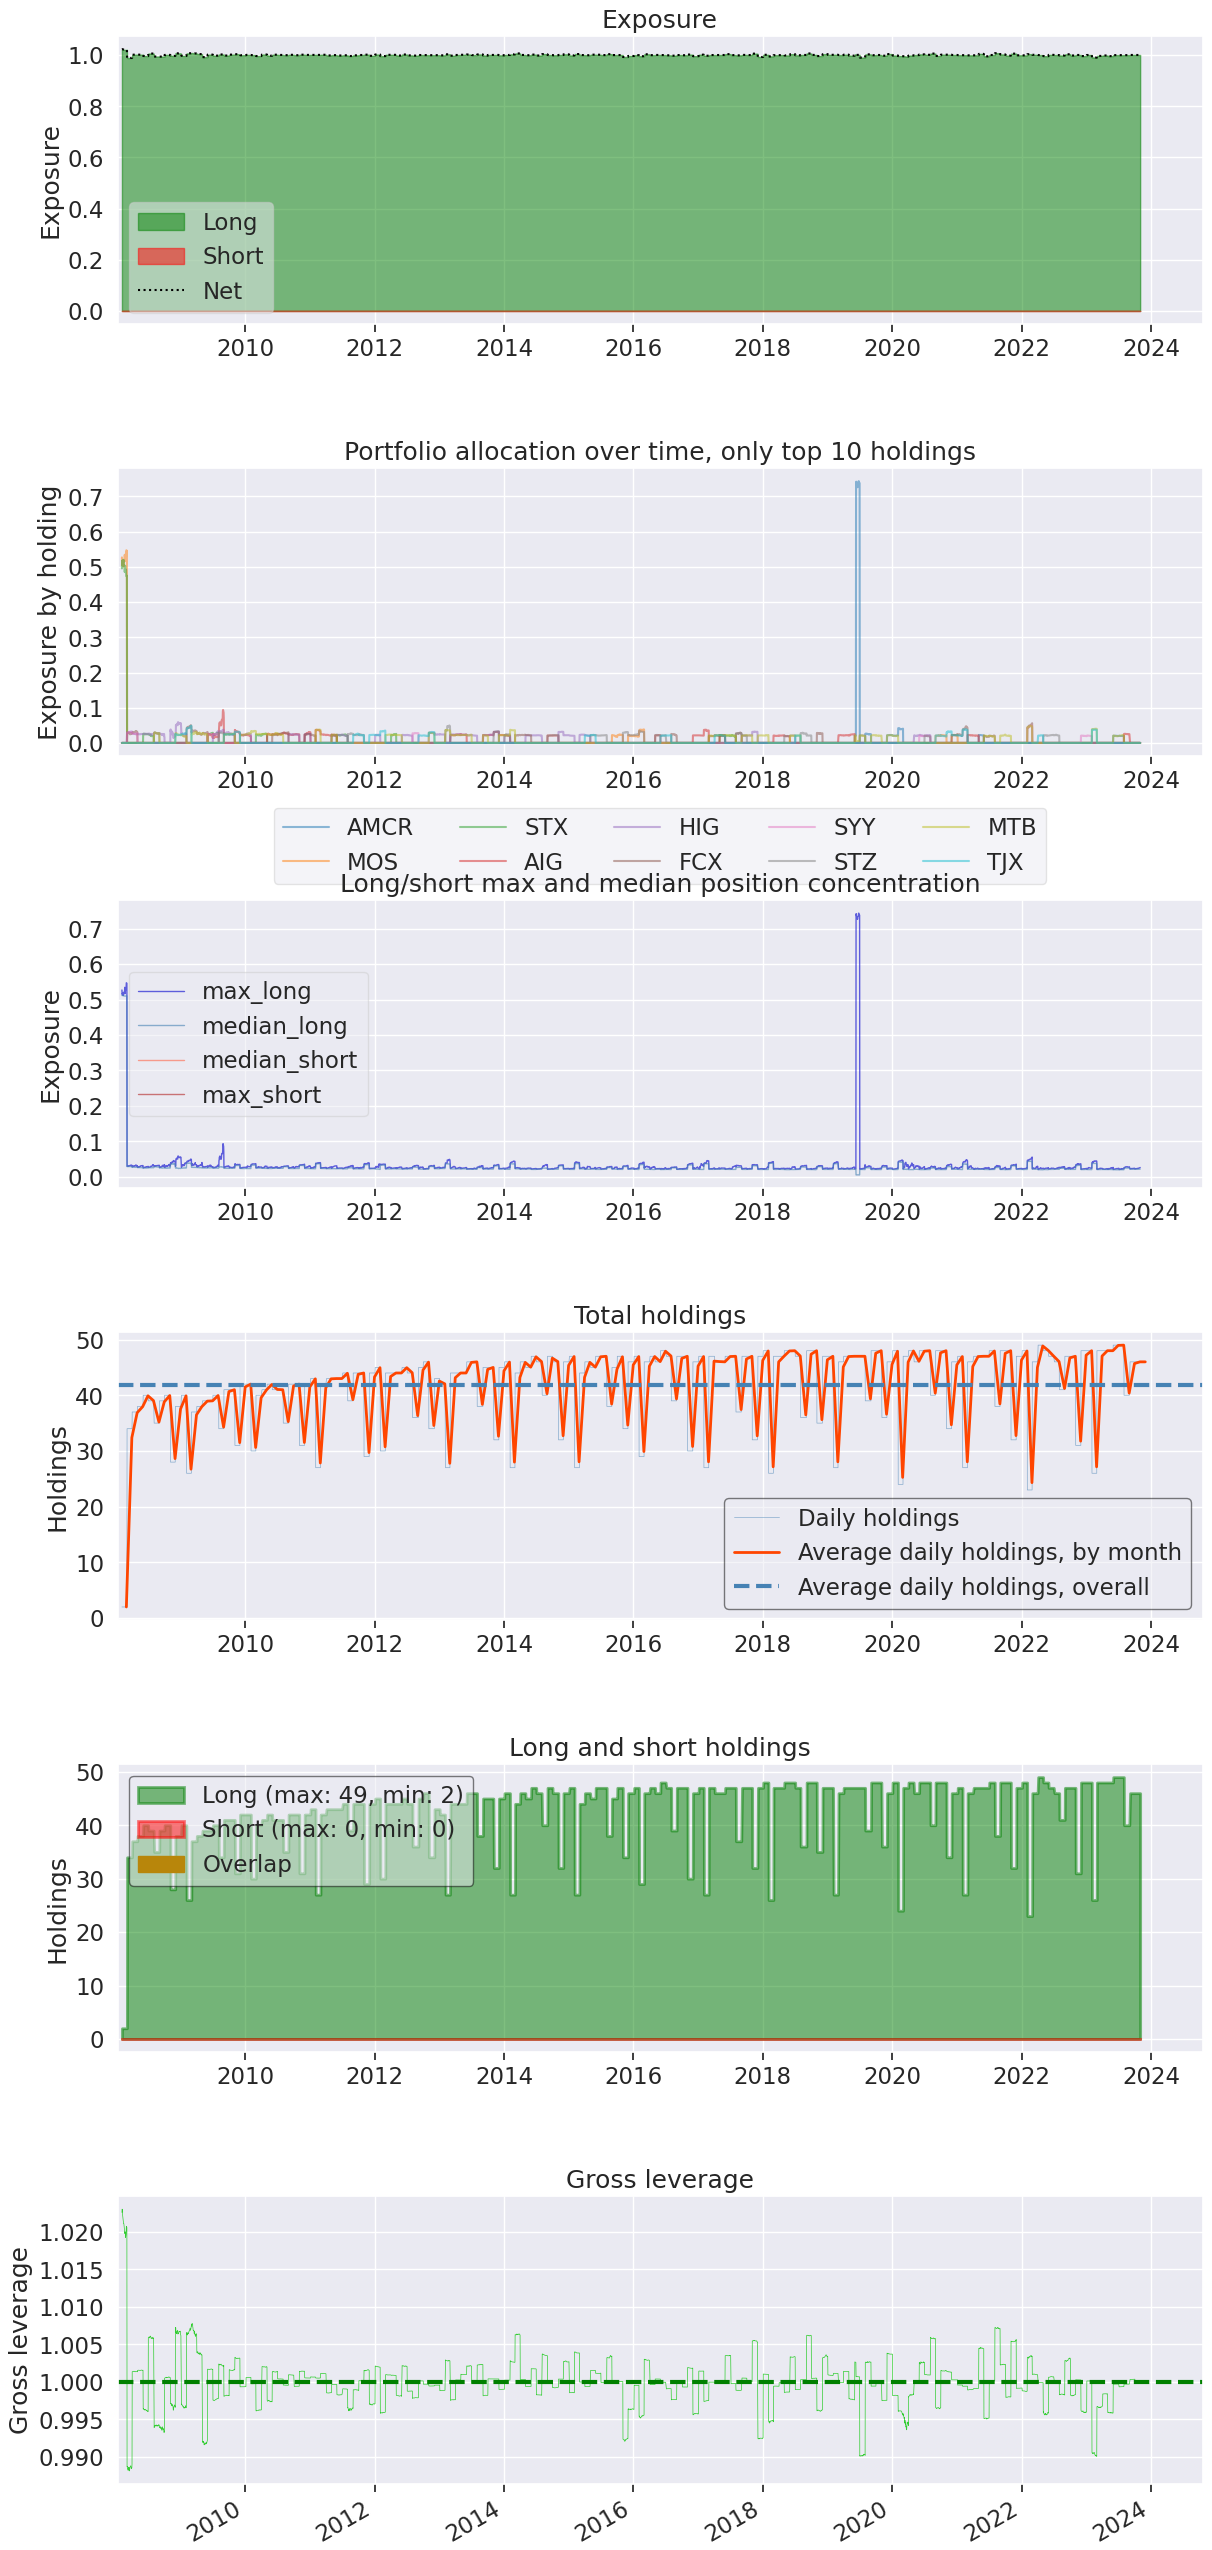

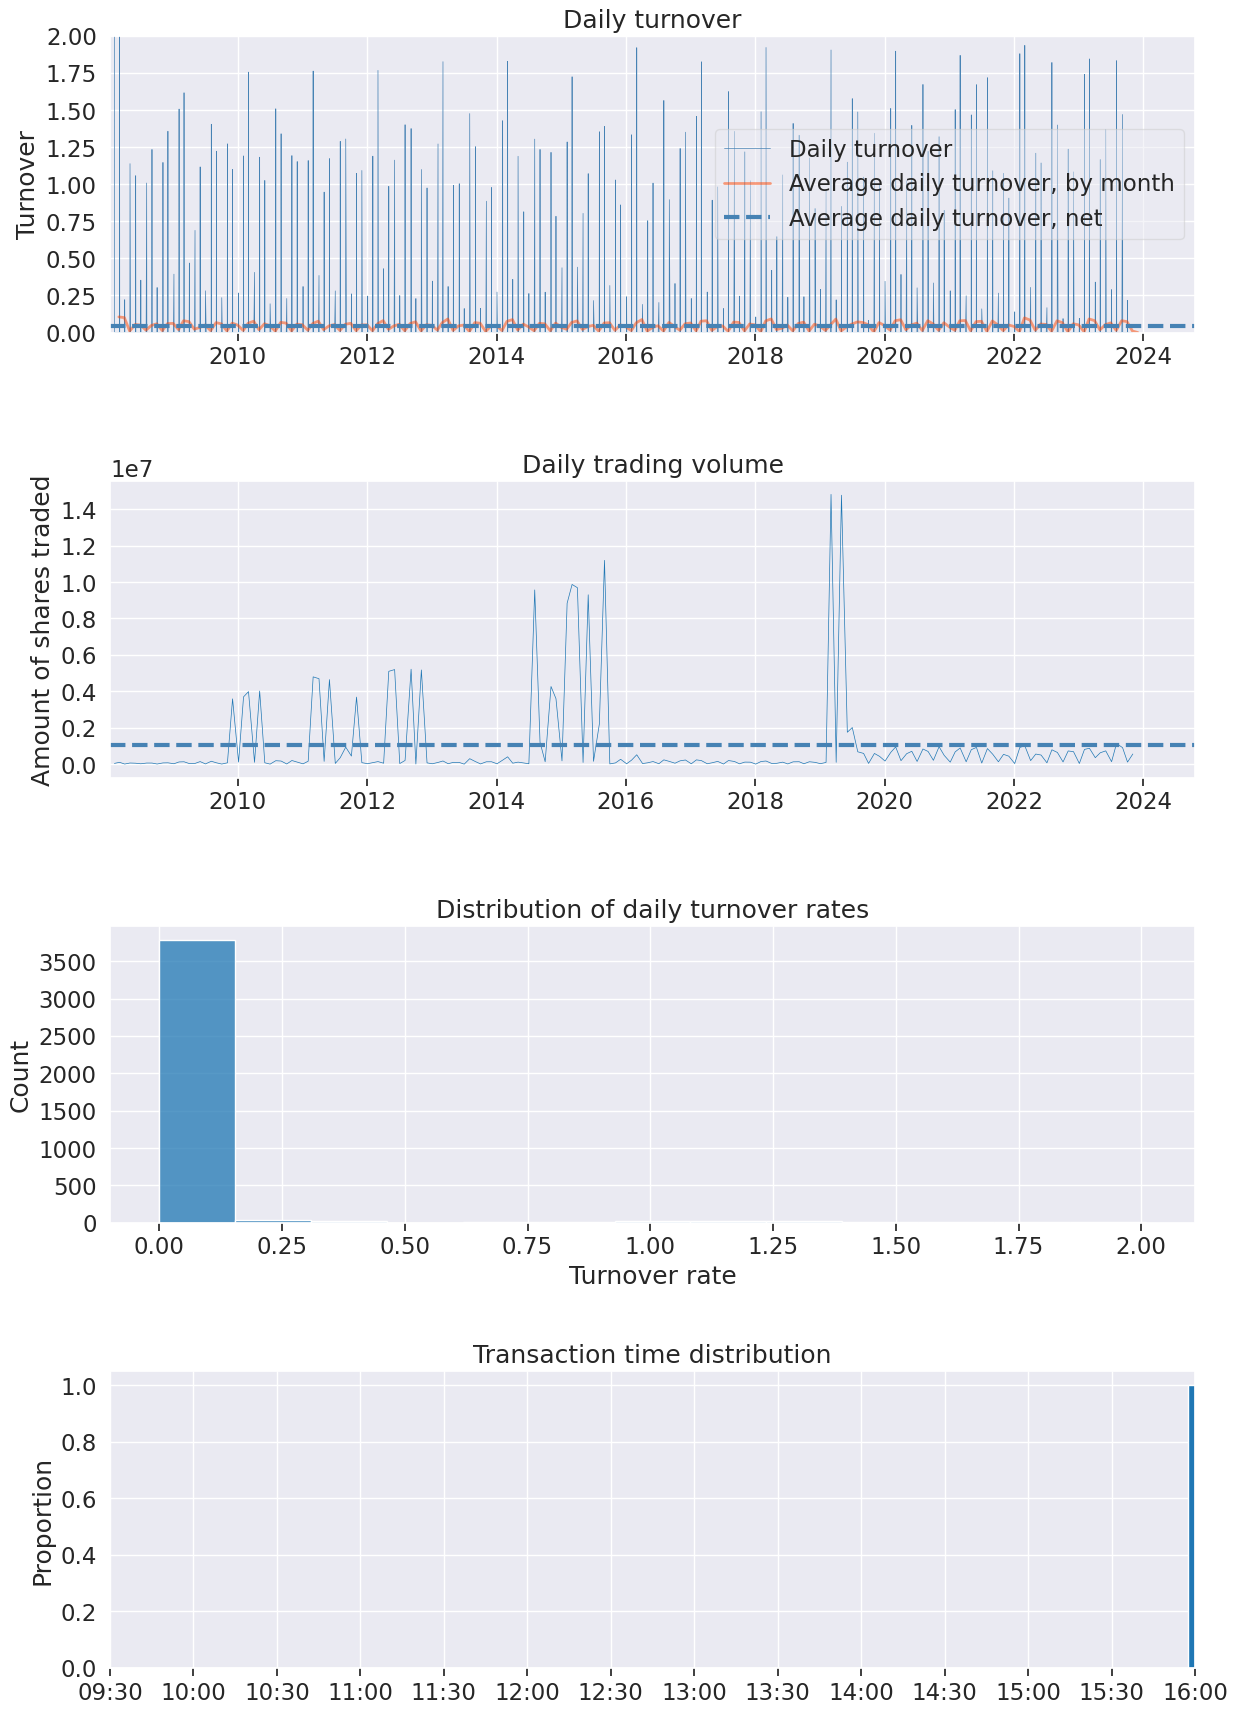

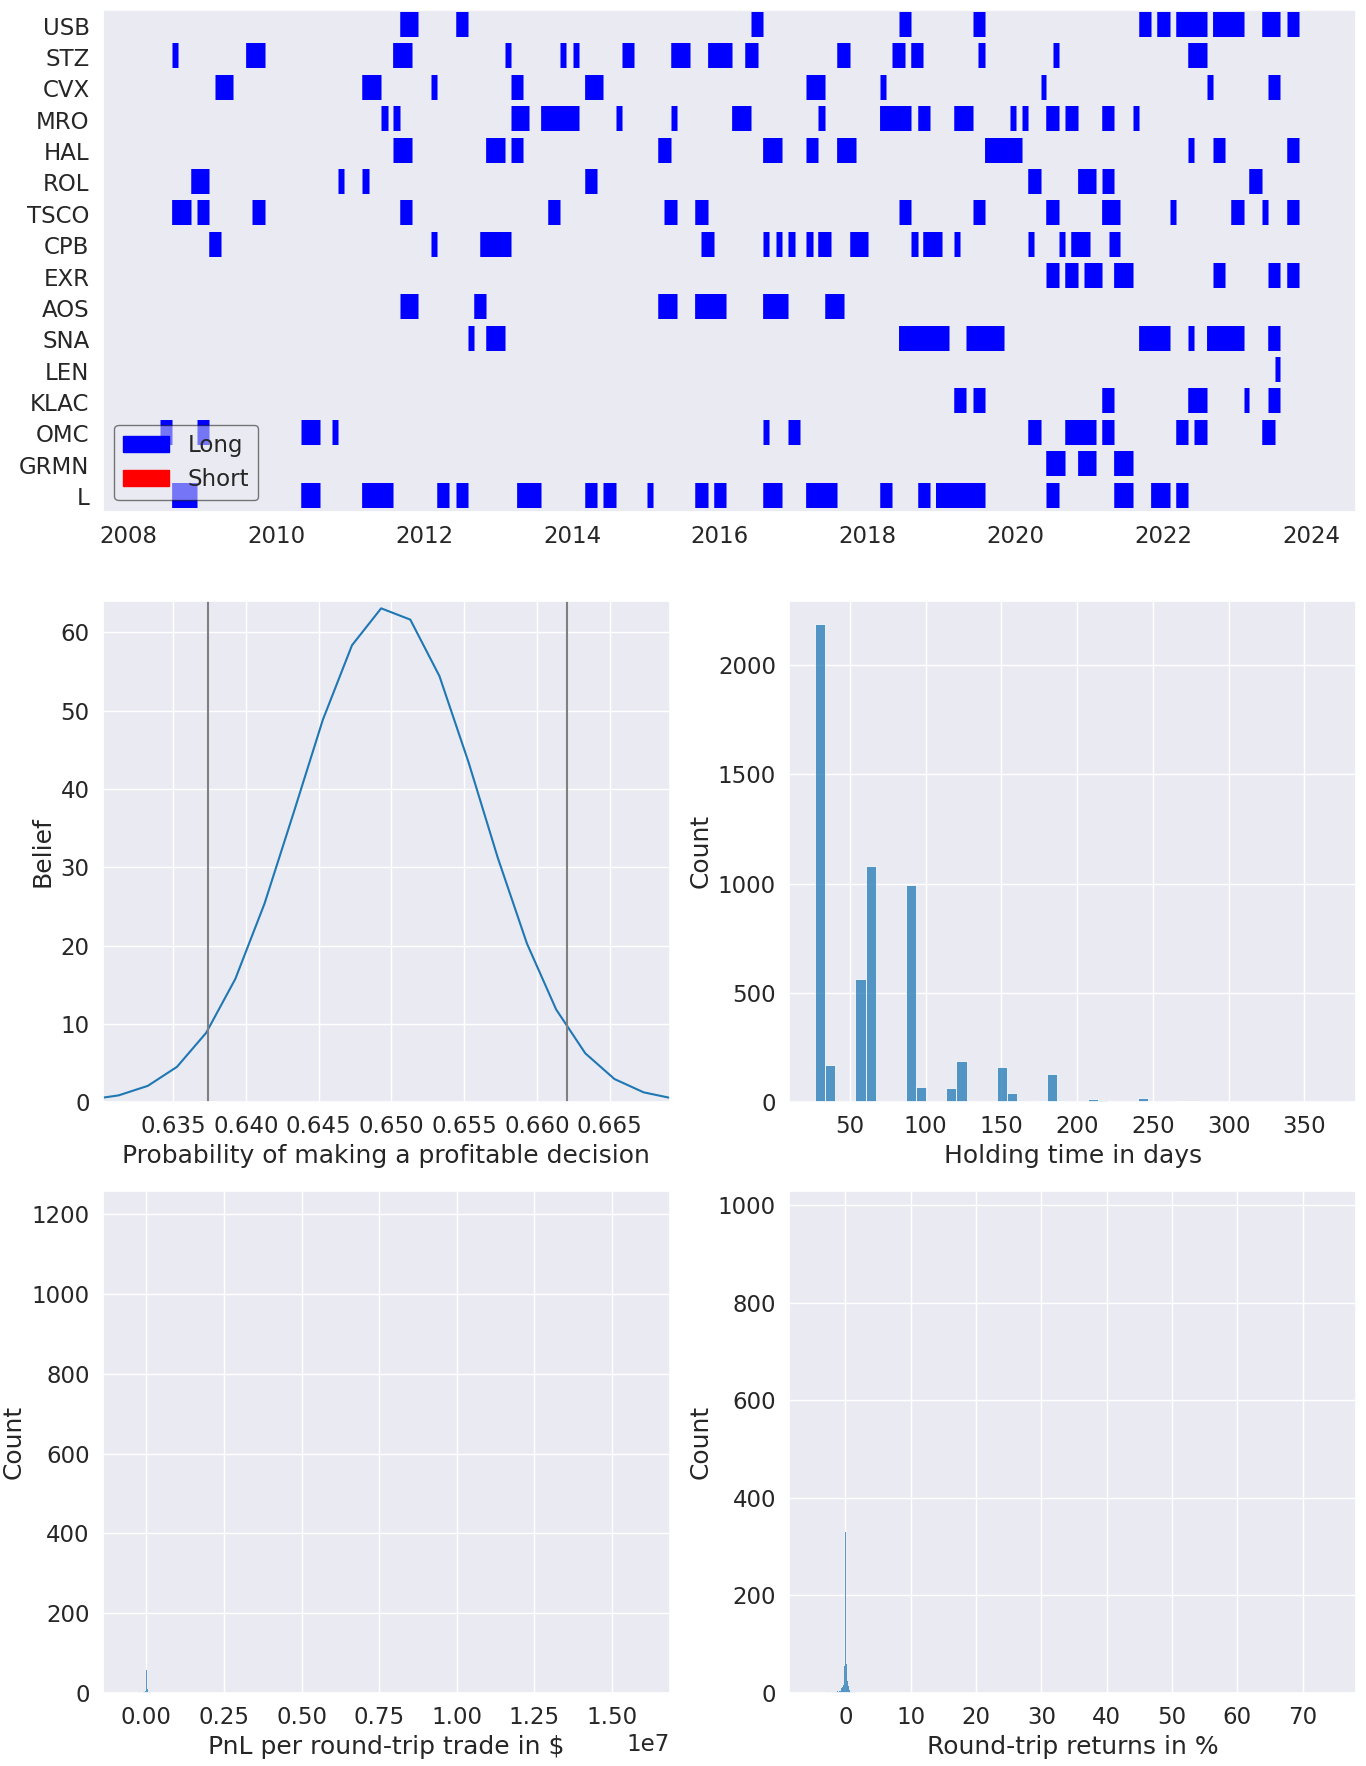

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import pyfolio as pf
import warnings
from utils import (
    get_russell1000_data,
    get_russell2000_data,
    get_sp500_etf_data,
)

warnings.filterwarnings("ignore")


def plotting(results, results_dir, benchmark, LIVE_DATE='2023-01-01'):
    """
    Plot various financial metrics and save results as a tear sheet.

    Parameters:
        results (pd.DataFrame): The backtest results data.
        results_dir (str): Directory where results will be saved.
        benchmark (pd.Series): Benchmark returns to compare against.
        LIVE_DATE (str): Date when the live trading started.
    """
    print(f'The Benchmark is {benchmark} results_dir is {results_dir}, LIVE_DATE is {LIVE_DATE}')
    # Extract performance metrics from the backtest results
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
    rewrite = True  # Flag to determine if existing plots should be overwritten

    # Define the filename for the aggregated full tear sheet
    aggregated_filename = "full_tearsheet.html"
    aggregated_file_path = os.path.join(results_dir, aggregated_filename)

    # Check if the file already exists
    if os.path.exists(aggregated_file_path):
        if rewrite:
            os.remove(aggregated_file_path)  # Remove the file if rewrite is True
        else:
            print('Plotting already exists and rewrite is set to False')
            return

    # Extract cash values from the results
    cash = results['ending_cash']

    # Create a plot for cash over time
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))  # Adjust figure size as needed
    ax.plot(cash.index, cash, label='Cash', color='orange')
    ax.set_title('Cash Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cash')
    ax.legend()
    ax.grid(True)

    fig.tight_layout()
    plt.savefig(os.path.join(results_dir, 'ending_cash.png'), bbox_inches='tight')

    # Generate and save a full tear sheet using pyfolio
    pf.create_full_tear_sheet(returns,
                              positions=positions,
                              transactions=transactions,
                              benchmark_rets=benchmark,
                              round_trips=True,
                              results_dir=results_dir,
                              live_start_date=LIVE_DATE
                              )


def process_backtest_results(results_dir):
    """
    Process backtest results from a given directory.

    Parameters:
        results_dir (str): Directory containing the backtest results and settings.
    """
    # Load the backtest settings from the JSON file
    settings_file = os.path.join(results_dir, 'BacktestSetting.json')
    if not os.path.exists(settings_file):
        print(f"Settings file not found in {results_dir}. Skipping...")
        return

    with open(settings_file, 'r') as f:
        BacktestSetting = json.load(f)

    # Determine the benchmark data based on the primary index in the settings
    if BacktestSetting['primaryindex'] == "S&P 500":
        benchmark = get_sp500_etf_data(BacktestSetting['start_date'], BacktestSetting['end_date']).fillna(0)
    elif BacktestSetting['primaryindex'] == "Russell 2000":
        benchmark = get_russell2000_data(BacktestSetting['start_date'], BacktestSetting['end_date']).fillna(0)
    elif BacktestSetting['primaryindex'] == "Russell 1000":
        benchmark = get_russell1000_data(BacktestSetting['start_date'], BacktestSetting['end_date']).fillna(0)
    else:
        print(f"Unknown primary index {BacktestSetting['primaryindex']} in {results_dir}. Skipping...").fillna(0)
        return

    # Load the results from the HDF5 file
    results_file = os.path.join(results_dir, 'results.h5')
    if not os.path.exists(results_file):
        print(f"Results file not found in {results_dir}. Skipping...")
        return

    results = pd.read_hdf(results_file, 'results')

    # Generate and save the plots and tear sheet
    LIVE_DATE = '2023-01-01'
    plotting(results, results_dir, benchmark, LIVE_DATE)


import os
import re

def main():
    """
    Main function to process all backtest results in the specified base directory.
    """
    base_dir = os.path.expanduser("~/repos/edge-seeker/zipline-x/AlphaFactor-Backtester-main/plots/temp")

    include = ['20241022_015936']
    # Loop through all directories in the base directory
    for dir_name in os.listdir(base_dir):
        if any(re.search(pattern, dir_name) for pattern in include):  # Use regex to match patterns in the include list
            results_dir = os.path.join(base_dir, dir_name)
            if os.path.isdir(results_dir):  # Process only directories
                print(f"Processing backtest results in {results_dir}...")
                try:                    
                    process_backtest_results(results_dir)
                except Exception as e:
                    print(e)


if __name__ == "__main__":
    main()



In [1]:
import matplotlib.pyplot as plt
import pyfolio as pf
results_path = f'/20241022_015936/results.h5'
# Generate a tear sheet
pf.create_simple_tear_sheet(returns)

# Save the current figure
plt.savefig('/Users/morgan/repos/edge-seeker/zipline-x/AlphaFactor-Backtester-main/tearsheets/tearsheet.png')

FileNotFoundError: [Errno 2] No such file or directory: 'backtest_results.pkl'

In [ ]:
import pyfolio as pf

# Assume results is from a Zipline backtest.
returns = results.portfolio.returns
pf.create_full_tear_sheet(returns)
import matplotlib.pyplot as plt

# After calling create_full_tear_sheet(), save the plots to a file.
plt.savefig('pyfolio_report.png')
pf.create_full_tear_sheet(returns, output='pyfolio_report.html')
